In [16]:
# NeuroMatch NeuroAI Project:

'''
Simple Poject: RNN in a Grid World with t-SNE Visualization / Exploring a 2D gridworld and remembering previous locations
Description:

The agent explores a 2D gridworld by making random moves (up, down, left, right). At random timepoints, the agent is queried:
“Where were you N steps ago?” -> we test different memory latencies -> plot output accuracy vs. latency to look at the “forgetting curve”.
Input: previous position, action taken (e.g., as one-hot vectors); the model must infer its new updated position.
After each move, update the hidden state of the model.
Output: With a certain probability (e.g. 10%), we ask “Where were you N steps ago?” (instead of “Where are you now” as in the demo)
-> the network must output the position at t-N as classification problem
-> Cross-entropy loss -> backprop the error.

'''
# Libraries:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import matplotlib.pyplot as plt
from tqdm import trange

In [17]:
# Model:
class MemoryRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.rnn = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, h):
        out, h = self.rnn(x.unsqueeze(1), h)
        return self.fc(out.squeeze(1)), h

# Utilities:
def pos_to_onehot(pos, grid_size):
    onehot = np.zeros(grid_size * grid_size)
    onehot[pos[0] * grid_size + pos[1]] = 1
    return onehot

def action_to_onehot(action):
    onehot = np.zeros(4)
    onehot[action] = 1
    return onehot

def move(pos, action, grid_size):
    x, y = pos
    if action == 0 and x > 0: x -= 1
    elif action == 1 and x < grid_size-1: x += 1
    elif action == 2 and y > 0: y -= 1
    elif action == 3 and y < grid_size-1: y += 1
    return (x, y)

In [18]:
# # Training:
# def train_model(N, grid_size=5, hidden_size=64, episodes=500, max_steps=100, query_prob=0.1):
#     input_size = grid_size * grid_size + 4
#     output_size = grid_size * grid_size
#     model = MemoryRNN(input_size, hidden_size, output_size)
#     optimizer = optim.Adam(model.parameters(), lr=0.005)
#     criterion = nn.CrossEntropyLoss()

#     for ep in trange(episodes, desc=f"Training N={N}"):
#         pos = (np.random.randint(grid_size), np.random.randint(grid_size))
#         history = deque(maxlen=N+1)
#         h = torch.zeros(1, 1, hidden_size)

#         for step in range(max_steps):
#             action = np.random.choice(4)
#             next_pos = move(pos, action, grid_size)
#             input_vec = np.concatenate([pos_to_onehot(pos, grid_size), action_to_onehot(action)])
#             input_tensor = torch.FloatTensor(input_vec).unsqueeze(0)
#             logits, h = model(input_tensor, h.detach())

#             history.append(pos)
#             pos = next_pos

#             if len(history) > N and random.random() < query_prob:
#                 target = history[0]
#                 target_idx = target[0] * grid_size + target[1]
#                 target_tensor = torch.LongTensor([target_idx])
#                 loss = criterion(logits, target_tensor)
#                 optimizer.zero_grad()
#                 loss.backward()
#                 optimizer.step()
#     return model

In [19]:
# Testing:
def evaluate_model(model, N, grid_size=5, episodes=100, max_steps=100, query_prob=0.1):
    correct, total = 0, 0
    model.eval()

    with torch.no_grad():
        for _ in trange(episodes, desc=f"Testing N={N}"):
            pos = (np.random.randint(grid_size), np.random.randint(grid_size))
            history = deque(maxlen=N+1)
            h = torch.zeros(1, 1, model.rnn.hidden_size)

            for _ in range(max_steps):
                action = np.random.choice(4)
                next_pos = move(pos, action, grid_size)
                input_vec = np.concatenate([pos_to_onehot(pos, grid_size), action_to_onehot(action)])
                input_tensor = torch.FloatTensor(input_vec).unsqueeze(0)
                logits, h = model(input_tensor, h)

                history.append(pos)
                pos = next_pos

                if len(history) > N and random.random() < query_prob:
                    target = history[0]
                    target_idx = target[0] * grid_size + target[1]
                    pred_idx = torch.argmax(logits).item()
                    correct += (pred_idx == target_idx)
                    total += 1
    return correct / total if total > 0 else 0

# # Full experiment:
# def run_generalization_forgetting_curve(max_n=8):
#     acc = []
#     for N in range(1, max_n+1):
#         model = train_model(N)
#         accuracy = evaluate_model(model, N)
#         acc.append(accuracy)
#     return acc

In [20]:
# # Run:
# forgetting_curve = run_generalization_forgetting_curve()

# plt.figure(figsize=(7, 5))
# plt.plot(range(1, len(forgetting_curve)+1), forgetting_curve, marker='o')
# plt.xlabel("N-back (Latency)")
# plt.ylabel("Generalization Accuracy")
# plt.title("Forgetting Curve – Generalization on Unseen Episodes")
# plt.grid(True)
# plt.show()

In [21]:
#Training with periodic probes
def train_with_probes(
        N: int,
        *,
        grid_size: int     = 5,
        hidden_size: int   = 64,
        max_steps: int     = 100,
        query_prob: float  = 0.10,
        probe_every: int   = 500,     # evaluate every X updates
        total_updates: int = 5000,    # stop after this many updates
):
    """
    Train a fresh MemoryRNN on the N‑back task and measure generalization
    accuracy every `probe_every` optimizer steps.

    Returns
    -------
    model : trained MemoryRNN
    curve : list[tuple[int, float]]
        (update_count, accuracy) pairs collected during training
    """
    # --- build model ---------------------------------------------------
    input_size  = grid_size * grid_size + 4
    output_size = grid_size * grid_size
    model       = MemoryRNN(input_size, hidden_size, output_size)
    criterion   = nn.CrossEntropyLoss()
    optimizer   = optim.Adam(model.parameters(), lr=0.005)

    updates = 0
    curve   = []               # (update#, accuracy)

    # --- training loop -------------------------------------------------
    episode = 0
    pbar = trange(total_updates // probe_every + 1,
                  desc=f"Training N={N}", leave=False)
    while updates < total_updates:
        episode += 1
        pos     = (np.random.randint(grid_size), np.random.randint(grid_size))
        hist    = deque(maxlen=N + 1)
        h       = torch.zeros(1, 1, hidden_size)

        for _ in range(max_steps):
            # ----- forward --------------------------------------------
            act      = np.random.choice(4)
            next_pos = move(pos, act, grid_size)

            x_vec  = np.concatenate([pos_to_onehot(pos, grid_size),
                                     action_to_onehot(act)])
            x      = torch.as_tensor(x_vec, dtype=torch.float32).unsqueeze(0)
            logits, h = model(x, h.detach())

            hist.append(pos)
            pos = next_pos

            # ----- training query -------------------------------------
            if len(hist) > N and random.random() < query_prob:
                tgt_idx = hist[0][0] * grid_size + hist[0][1]
                tgt     = torch.tensor([tgt_idx], dtype=torch.long)

                loss = criterion(logits, tgt)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                updates += 1

                # ----- periodic probe ---------------------------------
                if updates % probe_every == 0 or updates == total_updates:
                    model.eval()
                    acc = evaluate_model(model, N,
                                         grid_size=grid_size,
                                         episodes=100,
                                         max_steps=max_steps,
                                         query_prob=query_prob)
                    model.train()
                    curve.append((updates, acc))
                    pbar.update(1)
                    pbar.set_postfix(acc=f"{acc:.3f}")
                    if updates >= total_updates:
                        pbar.close()
                        return model, curve
    pbar.close()
    return model, curve

In [22]:
all_curves = {}
for N in range(1, 9):
    _, curve = train_with_probes(N,
                                 grid_size=5,
                                 hidden_size=64,
                                 max_steps=100,
                                 query_prob=0.10,
                                 probe_every=500,
                                 total_updates=5000)
    all_curves[N] = curve

Streaming output truncated to the last 5000 lines.


Testing N=3:  88%|████████▊ | 88/100 [00:03<00:00, 22.67it/s]


Testing N=3:  91%|█████████ | 91/100 [00:03<00:00, 23.07it/s]


Testing N=3:  94%|█████████▍| 94/100 [00:03<00:00, 22.93it/s]


Testing N=3:  97%|█████████▋| 97/100 [00:03<00:00, 22.46it/s]


Testing N=3: 100%|██████████| 100/100 [00:03<00:00, 27.12it/s]


Training N=3:  91%|█████████ | 10/11 [01:06<00:06,  6.60s/it, acc=0.443]

Training N=3:  91%|█████████ | 10/11 [01:06<00:06,  6.60s/it, acc=0.348]

                                                                        

Training N=4:   0%|          | 0/11 [00:00<?, ?it/s]


Testing N=4:   0%|          | 0/100 [00:00<?, ?it/s]


Testing N=4:   4%|▍         | 4/100 [00:00<00:02, 32.61it/s]


Testing N=4:   8%|▊         | 8/100 [00:00<00:02, 31.07it/s]


Testing N=4:  12%|█▏        | 12/100 [00:00<00:03, 28.49it/s]


Testing N=4:  15%|█▌        | 15/100 [00:00<00:02, 28.63it/s]


Testing N=4:  18%|█▊        | 18/100 [00

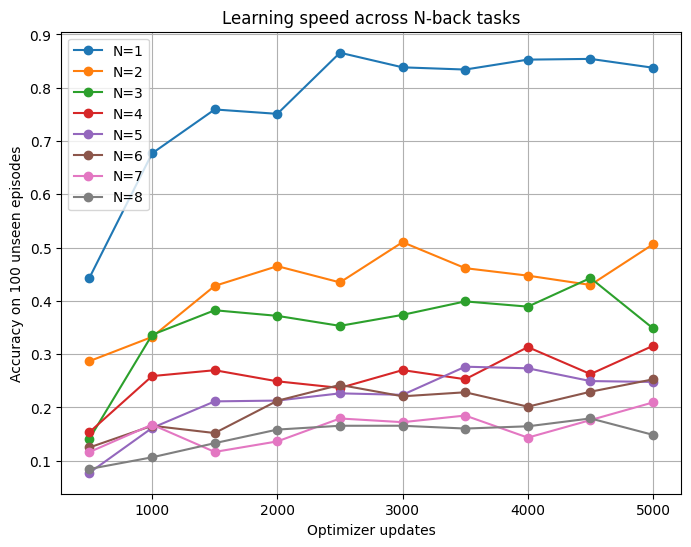

In [23]:
plt.figure(figsize=(8, 6))
for N, curve in all_curves.items():
    x, y = zip(*curve)
    plt.plot(x, y, marker='o', label=f"N={N}")
plt.xlabel("Optimizer updates")
plt.ylabel("Accuracy on 100 unseen episodes")
plt.title("Learning speed across N‑back tasks")
plt.legend()
plt.grid(True)
plt.show()
